In [1]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from torchvision.datasets import CIFAR10
from torchvision.transforms import *
from tqdm.notebook import tqdm

In [4]:
from torch.utils.data.dataset import Subset
from torchvision.transforms import InterpolationMode
# BICUBIC = InterpolationMode.BICUBIC
from torchvision.transforms.v2 import AutoAugmentPolicy, functional as F, InterpolationMode, Transform
from torchvision.transforms import v2
import torchvision
from torch.utils.data import DataLoader

# def _convert_image_to_rgb(image):
#     return image.convert("RGB")


# # def _transform(n_px):
# #     return Compose([
# #         Resize(n_px, interpolation=BICUBIC),
# #         CenterCrop(n_px),
# #         _convert_image_to_rgb,
# #         ToTensor(),
# #         Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
# #     ])

# def _transform(n_px):
#    v2.Compose([
#     v2.Resize((224, 224), antialias=True),
#     v2.ToTensor(),
#     v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
#     ])

# transforms = _transform(224)
CIFAR_PATH = "../dataset/cifar"
CIFAR_INDICES = "../dataset/cifar/cifar1098_idxs.npy"

train_transform = v2.Compose([
    v2.RandomResizedCrop((224, 224), scale=(0.9, 1.0), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])

val_transform = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])


trainset = torchvision.datasets.CIFAR10(root=CIFAR_PATH, train=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root=CIFAR_PATH, train=True, transform=val_transform)
test_dataset = torchvision.datasets.CIFAR10(root=CIFAR_PATH, train=False, transform=val_transform)

idxs = np.load(CIFAR_INDICES).astype('int')
val_indices = []
train_indices = []

for i in range(len(idxs)):
    if idxs[i]:
        val_indices.append(i)
    else:
        train_indices.append(i)

val_dataset = Subset(valset, val_indices)
train_dataset = Subset(trainset, train_indices)
print(len(val_dataset), len(train_dataset))

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=12)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=12)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=12)


/home/santosh.sanjeev/.conda/envs/nunoodles/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


5000 45000


/home/santosh.sanjeev/.conda/envs/nunoodles/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
device = 'cuda'
def validate(model):
  preds = []
  labels = []
  for x, y in tqdm(valloader):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

def test(model):
  preds = []
  labels = []
  for x, y in tqdm(testloader):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

In [6]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, feature_dim, num_classes, normalize=False, initial_weights=None):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.classification_head = torch.nn.Linear(feature_dim, num_classes)
        self.normalize = normalize
        if not self.normalize:
            print('normalize skipped.')

        if initial_weights is not None and type(initial_weights) == tuple:
            print('tuple.')
            w, b = initial_weights
            self.classification_head.weight = torch.nn.Parameter(w.clone())
            self.classification_head.bias = torch.nn.Parameter(b.clone())
        else:
            if initial_weights is None:
                initial_weights = torch.zeros_like(self.classification_head.weight)
                torch.nn.init.kaiming_uniform_(initial_weights, a=math.sqrt(5))
            self.classification_head.weight = torch.nn.Parameter(initial_weights.clone())
            # Note: modified. Initial bug in forgetting to zero bias.
            self.classification_head.bias = torch.nn.Parameter(torch.zeros_like(self.classification_head.bias))

        # Note: modified. Get rid of the language part.
        delattr(self.model, 'transformer')

    def forward(self, images):
        features = self.model.encode_image(images).float()
        if self.normalize:
            features = features / features.norm(dim=-1, keepdim=True)
        logits = self.classification_head(features)
        return logits

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
state_dicts = []

for f in sorted(os.listdir()):
  print(f)
  if f[-2:] == 'pt':
    print(f'Loading {f}')
    state_dicts.append(torch.load(f, map_location=device))

checkpoint_10.1.pt
Loading checkpoint_10.1.pt


In [5]:
def get_model(state_dicts, alphal):
  model, _ = clip.load('ViT-B/32')
  feature_dim = state_dicts[0]['classification_head.weight'].shape[1]
  num_classes = state_dicts[0]['classification_head.weight'].shape[0]
  normalize = True
  model = ModelWrapper(model, feature_dim, num_classes, normalize)
  sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
  for i in range(1, len(state_dicts)):
      for k in state_dicts[i].keys():
          sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
  model.load_state_dict(sd)
  model = model.to(device)
  return model

In [13]:
val_results = []
test_results = []

for i in range(len(state_dicts)):
  model, _ = clip.load('ViT-B/32')
  feature_dim = state_dicts[0]['classification_head.weight'].shape[1]
  num_classes = state_dicts[0]['classification_head.weight'].shape[0]
  normalize = True
  model = ModelWrapper(model, feature_dim, num_classes, normalize)
  model.load_state_dict(state_dicts[i])
  model = model.to(device)
  
  val_results.append(validate(model))
  test_results.append(test(model))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Model 5')])

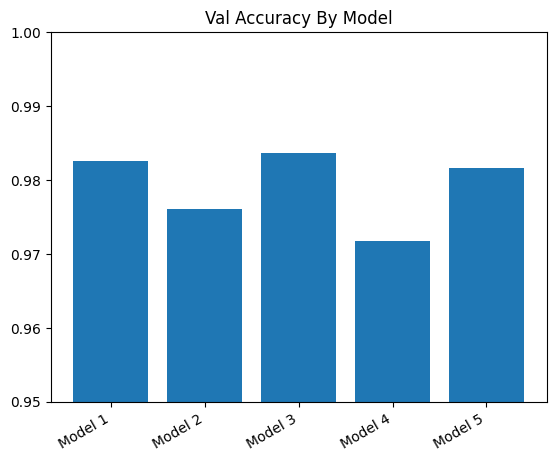

In [16]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, val_results)
plt.title("Val Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Model 5')])

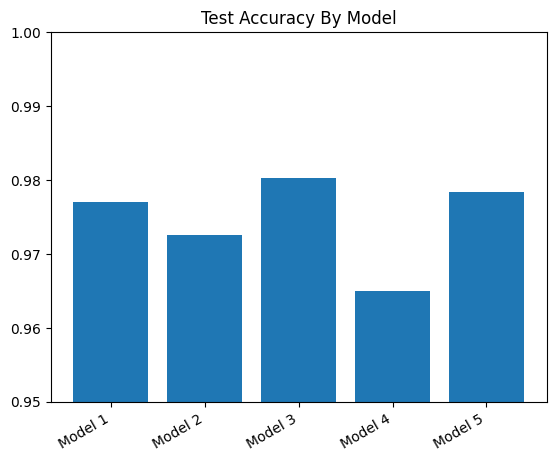

In [14]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

**UNIFORM SOUP**

In [15]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(state_dicts, alphal)
test_results.append(test(model))

  0%|          | 0/79 [00:00<?, ?it/s]

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Model 5'),
  Text(5, 0, 'Uniform Soup')])

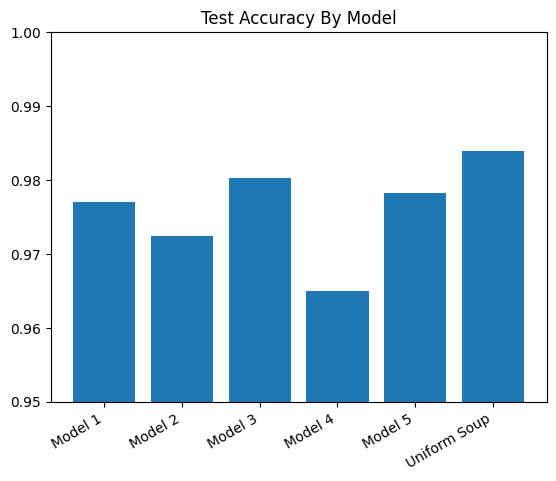

In [17]:
names.append("Uniform Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

**GREEDY SOUP ON VAL SET**

In [18]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)
  
  # benchmark and conditionally append
  model = get_model(state_dicts, alphal)
  current = validate(model)
  print(f'Models {ingredient_indices} got {current*100}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices



  0%|          | 0/40 [00:00<?, ?it/s]

Models [2, 0] got 98.69999885559082% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [2, 0, 4] got 98.87999892234802% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [2, 0, 4, 1] got 98.83999824523926% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [2, 0, 4, 3] got 98.83999824523926% on validation.


**GREEDY SOUP TEST SET**

In [19]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)

test_results.append(test(model))

  0%|          | 0/79 [00:00<?, ?it/s]

In [20]:
print(names, test_results)
print(names, val_results)

['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Uniform Soup'] [0.9769999980926514, 0.9724999666213989, 0.9802999496459961, 0.9649999737739563, 0.9782999753952026, 0.9838999509811401, 0.984499990940094]
['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Uniform Soup'] [0.9825999736785889, 0.9759999513626099, 0.9835999608039856, 0.9717999696731567, 0.9815999865531921]


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Model 5'),
  Text(5, 0, 'Uniform Soup'),
  Text(6, 0, 'Greedy Soup')])

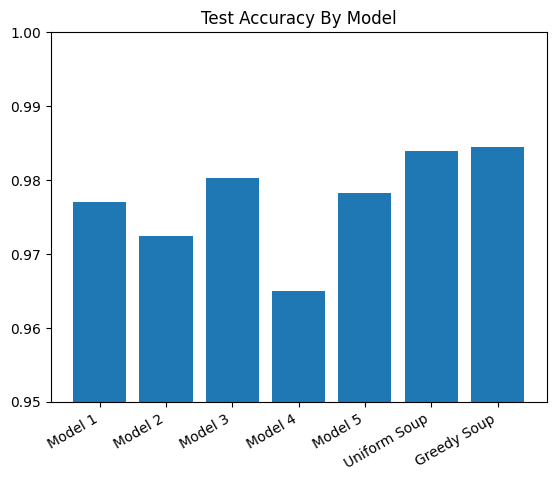

In [21]:
names.append("Greedy Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

**FGE of checkpoint_10.4**

In [10]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console kernel kernelspec migrate qtconsole run
troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [6]:

import pandas as pd
model_paths = [ '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-11.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-13.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-15.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-17.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-19.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-21.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-23.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-25.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-27.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-29.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-31.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-33.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-35.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-37.pt', \
                '/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-39.pt', \
                '/l/users/santosh.sanjeev/model_soups/final_models/CLIP_wo_mixup/2024-01-07_02-48-23/hparam_2024-01-07_06-45-10/best_checkpoint.pth'
                ]#, '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/cnn_v1/model_7.pth','/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/cnn_v1/model_7.pth']#, '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/model_1.pth']

model_names = [os.path.splitext(os.path.basename(path))[0] for path in model_paths]

device = 'cuda'
state_dicts_test = []
val_results = []
test_results = []
for model_path, model_name in zip(model_paths, model_names):
    print(model_path)
    checkpoint = torch.load(model_path)
    if model_path != '/l/users/santosh.sanjeev/model_soups/final_models/CLIP_wo_mixup/2024-01-07_02-48-23/hparam_2024-01-07_06-45-10/best_checkpoint.pth':
        state_dicts_test.append(torch.load(model_path)['model_state'])
    else:
        state_dicts_test.append(torch.load(model_path, map_location=device)['model'])
    model, _ = clip.load('ViT-B/32')
    feature_dim = state_dicts_test[-1]['classification_head.weight'].shape[1]
    num_classes = state_dicts_test[-1]['classification_head.weight'].shape[0]
    normalize = True
    model = ModelWrapper(model, feature_dim, num_classes, normalize)
    model.load_state_dict(state_dicts_test[-1])
    model = model.to(device)
    val_accuracy = validate(model)
    test_accuracy = test(model)
    val_results.append({'Model Name': model_name,
                                    'Val Accuracy': val_accuracy})
    test_results.append({'Model Name': model_name,
                                    'Test Accuracy': test_accuracy})
    print(val_accuracy, test_accuracy)

results_test_df = pd.DataFrame(test_results)
results_val_df = pd.DataFrame(val_results)

alphal = [1 / len(state_dicts_test) for i in range(len(state_dicts_test))]
model = get_model(state_dicts_test, alphal)
print(test(model))

/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-11.pt


  0%|          | 0/40 [00:00<?, ?it/s]

/home/santosh.sanjeev/.conda/envs/nunoodles/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

0.9801999926567078 0.9749999642372131
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-13.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.975600004196167 0.9651999473571777
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-15.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9807999730110168 0.975600004196167
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-17.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9761999845504761 0.9651999473571777
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-19.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9803999662399292 0.972599983215332
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-21.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9723999500274658 0.9667999744415283
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-23.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9799999594688416 0.9735999703407288
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-25.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.972599983215332 0.9660999774932861
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-27.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9777999520301819 0.9729999899864197
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-29.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9691999554634094 0.960599958896637
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-31.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9797999858856201 0.9724999666213989
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-33.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.967799961566925 0.9667999744415283
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-35.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9779999852180481 0.9702000021934509
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-37.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9649999737739563 0.9620999693870544
/home/santosh.sanjeev/Projects/model-soups/noodles/Fis&Fus/clip_checkpoints/fge-39.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9749999642372131 0.9686999917030334
/l/users/santosh.sanjeev/model_soups/final_models/CLIP_wo_mixup/2024-01-07_02-48-23/hparam_2024-01-07_06-45-10/best_checkpoint.pth


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9873999953269958 0.9820999503135681


  0%|          | 0/79 [00:00<?, ?it/s]

0.9791999459266663


: 

In [7]:
results_test_df

,Model Name,Test Accuracy
0,checkpoint_10.4,0.9650
1,fge-17,0.9768
2,fge-19,0.9770
3,fge-21,0.9770
4,fge-23,0.9773
5,fge-25,0.9773
6,fge-27,0.9774
7,fge-29,0.9774
8,fge-31,0.9779
9,fge-33,0.9779


In [16]:
results_test_df

,Model Name,Test Accuracy
0,checkpoint_10.4,0.9650
1,fge-17,0.9768
2,fge-19,0.9770
3,fge-21,0.9770
4,fge-23,0.9773
5,fge-25,0.9773
6,fge-27,0.9774
7,fge-29,0.9774
8,fge-31,0.9779
9,fge-33,0.9779


In [13]:
ls = list(results_val_df['Val Accuracy'])
print(ls)
ranked_candidates = [i for i in range(len(state_dicts_test))]
ranked_candidates.sort(key=lambda x: -ls[x])

current_best = ls[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts_test)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts_test))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)
  
  # benchmark and conditionally append
  model = get_model(state_dicts_test, alphal)
  current = validate(model)
  print(f'Models {ingredient_indices} got {current*100}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices



[0.9717999696731567, 0.9827999472618103, 0.9829999804496765, 0.9827999472618103, 0.9827999472618103, 0.9827999472618103, 0.9835999608039856, 0.9833999872207642, 0.9833999872207642, 0.9833999872207642, 0.983199954032898, 0.9835999608039856, 0.9833999872207642]


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 11] got 98.33999872207642% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 7] got 98.35999608039856% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 8] got 98.35999608039856% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 9] got 98.33999872207642% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 12] got 98.33999872207642% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 10] got 98.33999872207642% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 2] got 98.27999472618103% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 1] got 98.24000000953674% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 3] got 98.27999472618103% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 4] got 98.29999804496765% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 5] got 98.29999804496765% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [6, 0] got 98.33999872207642% on validation.


**GREEDY SOUP**

In [14]:
alphal = [0 for i in range(len(state_dicts_test))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts_test, alphal)

test_results.append(test(model))

  0%|          | 0/79 [00:00<?, ?it/s]

In [17]:
print(test_results[-1])

0.977400004863739


**FGE of checkpoint_10.1**

In [18]:

model_paths = [ '/home/santosh.sanjeev/model-soups/mode-connectivity/NOTEBOOKS/checkpoint_10.1.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-11.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-13.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-15.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-17.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-19.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-21.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-23.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-25.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-27.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-29.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-31.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-33.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-35.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-37.pt', \
                '/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-39.pt', \
                ]#, '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/cnn_v1/model_7.pth','/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/cnn_v1/model_7.pth']#, '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/model_1.pth']

model_names = [os.path.splitext(os.path.basename(path))[0] for path in model_paths]

device = 'cuda'
state_dicts_test = []
val_results = []
test_results = []
for model_path, model_name in zip(model_paths, model_names):
    print(model_path)
    checkpoint = torch.load(model_path)
    if model_path != '/home/santosh.sanjeev/model-soups/mode-connectivity/NOTEBOOKS/checkpoint_10.1.pt':
        state_dicts_test.append(torch.load(model_path)['model_state'])
    else:
        state_dicts_test.append(torch.load(model_path, map_location=device))
    model, _ = clip.load('ViT-B/32')
    feature_dim = state_dicts_test[-1]['classification_head.weight'].shape[1]
    num_classes = state_dicts_test[-1]['classification_head.weight'].shape[0]
    normalize = True
    model = ModelWrapper(model, feature_dim, num_classes, normalize)
    model.load_state_dict(state_dicts_test[-1])
    model = model.to(device)
    val_accuracy = validate(model)
    test_accuracy = test(model)
    val_results.append({'Model Name': model_name,
                                    'Val Accuracy': val_accuracy})
    test_results.append({'Model Name': model_name,
                                    'Test Accuracy': test_accuracy})
    print(val_accuracy, test_accuracy)

results_test_df = pd.DataFrame(test_results)
results_val_df = pd.DataFrame(val_results)

alphal = [1 / len(state_dicts_test) for i in range(len(state_dicts_test))]
model = get_model(state_dicts_test, alphal)
print(test(model))

/home/santosh.sanjeev/model-soups/mode-connectivity/NOTEBOOKS/checkpoint_10.1.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9825999736785889 0.9769999980926514
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-11.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9811999797821045 0.9718999862670898
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-13.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9829999804496765 0.9756999611854553
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-15.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9827999472618103 0.9764999747276306
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-17.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9829999804496765 0.9765999913215637
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-19.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9833999872207642 0.9765999913215637
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-21.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9833999872207642 0.9763999581336975
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-23.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9835999608039856 0.9761999845504761
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-25.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9835999608039856 0.9763999581336975
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-27.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9839999675750732 0.9765999913215637
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-29.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9843999743461609 0.9764999747276306
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-31.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9843999743461609 0.9764999747276306
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-33.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9845999479293823 0.9764999747276306
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-35.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9845999479293823 0.9765999913215637
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-37.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9845999479293823 0.9765999913215637
/home/santosh.sanjeev/model-soups/mode-connectivity/mode-connectivity/clipckpt_1_e-5/fge-39.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9847999811172485 0.9764999747276306


  0%|          | 0/79 [00:00<?, ?it/s]

0.9768999814987183


In [19]:
results_test_df

,Model Name,Test Accuracy
0,checkpoint_10.1,0.9770
1,fge-11,0.9719
2,fge-13,0.9757
3,fge-15,0.9765
4,fge-17,0.9766
5,fge-19,0.9766
6,fge-21,0.9764
7,fge-23,0.9762
8,fge-25,0.9764
9,fge-27,0.9766


In [20]:
results_val_df

,Model Name,Val Accuracy
0,checkpoint_10.1,0.9826
1,fge-11,0.9812
2,fge-13,0.9830
3,fge-15,0.9828
4,fge-17,0.9830
5,fge-19,0.9834
6,fge-21,0.9834
7,fge-23,0.9836
8,fge-25,0.9836
9,fge-27,0.9840


In [ ]:
ls = list(results_val_df['Val Accuracy'])
print(ls)
ranked_candidates = [i for i in range(len(state_dicts_test))]
ranked_candidates.sort(key=lambda x: -ls[x])

current_best = ls[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts_test)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts_test))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)
  
  # benchmark and conditionally append
  model = get_model(state_dicts_test, alphal)
  current = validate(model)
  print(f'Models {ingredient_indices} got {current*100}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices



**GREEDY SOUP**

In [21]:
alphal = [0 for i in range(len(state_dicts_test))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts_test, alphal)

test_results.append(test(model))
print(test_results[-1])

  0%|          | 0/79 [00:00<?, ?it/s]

0.9763999581336975
